In [114]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
def prepaer_df(df):
    columns = ['time', 'sex', 'child_offence', 'vegan', 'dvach', 'gender', 'rest', 'games', 'series', 'books', 'antisemetism', 'subject', 'crimea', 'putin', 'english', 'old_days','films']
    oldColumns = df.columns
    df = df.rename(columns=dict(zip(oldColumns, columns)) )
    df.time = pd.to_datetime(df.time)
    df.loc[df.sex == 'Мальчик' ,['sex']] = 0
    df.loc[df.sex == 'Девочка' ,['sex']] = 1
    df.loc[df.rest == 'Сычевать' ,['rest']] = 1
    df.loc[df.rest == 'Гулять' ,['rest']] = 0
    df = pd.get_dummies(df, drop_first=True,columns=['child_offence', 'dvach', 'gender', 'antisemetism', 'subject', 'crimea' ])
    df['putin_good'] = 0
    df.loc[(df.putin == 'Политик, лидер и боец') | (df.putin == 'Молодец'),['putin_good']]=1
    df['rebel'] = 1
    df.loc[(df.putin == 'Политик, лидер и боец') | (df.putin == 'Молодец'),['rebel']]=0
    df  =df.drop(columns=['putin'])
    df['month'] = df['time'].dt.month
    df['dayofweek'] = df['time'].dt.dayofweek
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df.loc[df['english'] == 'Оригатоё гайзаймас', ['english']] = 0
    df.loc[df['english'] == 'Чуть лучше, чем ничего', ['english']] = 1
    df.loc[df['english'] == 'Нормально', ['english']] = 2
    df.loc[df['english'] == 'Хорошо', ['english']] = 3
    df.loc[df['english'] == 'Отлично', ['english']] = 4
    df.loc[df['english'] == 'НЭЙТИВ ИНГЛИШ СПИКЕР', ['english']] = 5
    df.loc[df['old_days'] == 'Нет', ['old_days']] = 0
    df.loc[df['old_days'] != 'Нет', ['old_days']] = 1
    return df

In [115]:
df = pd.read_csv("form.csv")
df = prepaer_df(df)
labels = df["films"]
labels = labels.apply(lambda x: 1 if x.find('Аниме')  != -1 else 0)
train = df.drop(columns=['films','time'])

In [116]:
train= train.astype('int32')  #sex, rest, english, old_days

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    train,labels, test_size=0.2, random_state=25
)

In [118]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
def optimize(trials):
    space = {
        "num_round": 100,
        "learning_rate": hp.quniform("eta", 0.005, 0.05, 0.005),
        "max_depth": hp.quniform("max_depth", 3, 14, 1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.5, 1, 0.01),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
        "num_class": 2,
        "eval_metric": "merror",
        "objective": "multi:softprob",
        "nthread": 4,
        "silent": 1,
    }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best
def score(params):
    from sklearn.metrics import log_loss
    print("Training with params:")
    print(params)
    params["max_depth"] = int(params["max_depth"])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, params["num_round"])
    predictions = model.predict(dvalid)
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {"loss": score, "status": STATUS_OK}
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:                                 
{'colsample_bytree': 0.55, 'eval_metric': 'merror', 'gamma': 0.58, 'learning_rate': 0.01, 'max_depth': 13.0, 'min_child_weight': 6.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.8500000000000001}
[14:54:45] WARNING: ../src/learner.cc:541:            
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


	Score 0.5664202652871608                             


Training with params:                                                           
{'colsample_bytree': 0.9500000000000001, 'eval_metric': 'merror', 'gamma': 0.87, 'learning_rate': 0.02, 'max_depth': 10.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'obj

{'colsample_bytree': 0.4,
 'eta': 0.04,
 'gamma': 0.93,
 'max_depth': 8.0,
 'min_child_weight': 4.0,
 'subsample': 0.6000000000000001}

In [119]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params["eval_metric"] = "merror"
best_params["num_class"] = 2 
dtrain = xgb.DMatrix(train, labels)

In [120]:
%%time
xgbCvResult = xgb.cv(
    best_params, dtrain, num_boost_round=500, nfold=3, early_stopping_rounds=60
)

CPU times: user 3.56 s, sys: 107 ms, total: 3.67 s
Wall time: 472 ms


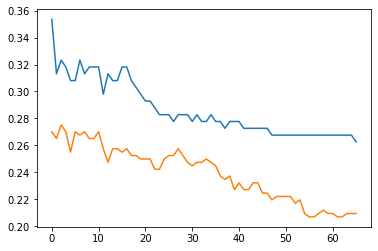

In [121]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["test-merror-mean"])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["train-merror-mean"]);

In [122]:
best_num_round = np.argmin(xgbCvResult["test-merror-mean"])
best_num_round

65

In [123]:
dtrain = xgb.DMatrix(X_train, y_train)
bestXgb = xgb.train(best_params, dtrain, num_boost_round=best_num_round)

In [124]:
dtest = xgb.DMatrix(X_test)
xgboost_predict_proba = bestXgb.predict(dtest)
 

In [125]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [126]:
roc_auc_score(y_test.values, xgboost_predict_proba)

0.6505376344086021

In [127]:
accuracy_score(y_test.values, xgboost_predict_proba)

0.825

In [128]:
import pickle

In [129]:
output = open('model.pkl', 'wb')
pickle.dump(bestXgb, output, 2)
output.close()

In [130]:
input = open('model.pkl', 'rb')
obj = pickle.load(input)
input.close()

In [131]:
train_predictions = obj.predict(  xgb.DMatrix(train) )
 
roc_auc_score(labels, train_predictions)

0.7311085972850678

In [132]:
accuracy_score(labels, train_predictions)

0.8080808080808081

In [134]:
!python fair_example.py "test_form.csv"  "ans.csv"